# CS 7641 Homework 1 - Fall 2020



Refs: 
- https://www.kaggle.com/cdabakoglu/heart-disease-classifications-machine-learning
- https://www.kaggle.com/arunmohan003/pruning-decision-trees
- https://www.studocu.com/da/document/danmarks-tekniske-universitet/introduktion-til-machine-learning-og-data-mining/obligatoriske-lektier/part-one-data-types-features-and-visualization/3113772/view
- https://github.com/JYORAM9/Abalone-Dataset/blob/master/RandomAbalone.ipynb

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import tree, svm, datasets, metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,StratifiedKFold, StratifiedShuffleSplit, cross_validate, GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from visualization import plot_2d_data, plot_2d_classifier
from scipy import stats
import seaborn as sns
import os

from visualization import get_colors
cm = get_colors(colormap='RdBu', n_colors=2)

## Loading Datasets

In [2]:
data = pd.read_csv("./data/abalone.csv")
data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [3]:
def ringCategorization(ring):
    if ring < 9: return '1'
    if 9 <= ring < 15: return '2'
    if 15 <= ring < 21: return '3'
    else: return '4'

In [4]:
data = data.apply(LabelEncoder().fit_transform)
data['Volume']= data['Length'] * data['Diameter'] * data['Height']
data['RingCat'] = data['Rings'].map(ringCategorization)
data.head(10)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Volume,RingCat
0,2,66,56,18,715,417,199,263,14,66528,2
1,2,45,36,17,285,178,94,113,6,27540,1
2,0,81,67,26,962,480,280,374,8,141102,1
3,2,63,56,24,718,400,225,273,9,84672,2
4,1,41,34,15,253,159,76,87,6,20910,1
5,1,60,43,18,463,254,152,207,7,46440,1
6,0,81,66,29,1109,441,280,592,19,155034,3
7,0,84,68,24,1097,552,296,462,15,137088,3
8,2,70,57,24,706,402,222,293,8,95760,1
9,0,85,71,29,1301,593,299,572,18,175015,3


- Sex - indicates sex of the abalone. M for male, F for female, and I for infant.
- Length - the length of the abalone in millimeters.
- Diameter - the diameter of the abalone in millimeters.
- Height - the height of the abalone in millimeters.
- Whole weight - the weight in grams of the whole abalone after capture.
- Shuckled weight - the weight of the abalone meat.
- Viscera weight - the weight in grams of the guts/intestines after the abalone has been bleeding.
- Shell weight - the weight in grams of the dried shell. The shell is porous and can carry a lot of water if not dried.
- Rings - the number of rings through the abalone shell. The age is equal to the number of rings plus 1.5

In [5]:
data.shape

(4177, 11)

In [6]:
correlation = data.corr()
correlation

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Volume
Sex,1.000000,-0.036006,-0.038846,-0.040559,-0.026480,-0.009979,-0.035252,-0.035159,-0.034546,-0.036508
Length,-0.036006,1.000000,0.986815,0.898495,0.945616,0.923686,0.914853,0.925637,0.556666,0.917003
Diameter,-0.038846,0.986815,1.000000,0.904767,0.946053,0.919422,0.911692,0.932714,0.574718,0.922002
Height,-0.040559,0.898495,0.904767,1.000000,0.900422,0.855481,0.874504,0.906738,0.608239,0.916186
Whole weight,-0.026480,0.945616,0.946053,0.900422,1.000000,0.973950,0.966996,0.966973,0.554945,0.956093
Shucked weight,-0.009979,0.923686,0.919422,0.855481,0.973950,1.000000,0.940029,0.909816,0.442772,0.931489
Viscera weight,-0.035252,0.914853,0.911692,0.874504,0.966996,0.940029,1.000000,0.926469,0.513213,0.942232
Shell weight,-0.035159,0.925637,0.932714,0.906738,0.966973,0.909816,0.926469,1.000000,0.630742,0.947081
Rings,-0.034546,0.556666,0.574718,0.608239,0.554945,0.442772,0.513213,0.630742,1.000000,0.538010
Volume,-0.036508,0.917003,0.922002,0.916186,0.956093,0.931489,0.942232,0.947081,0.538010,1.000000


<AxesSubplot:>

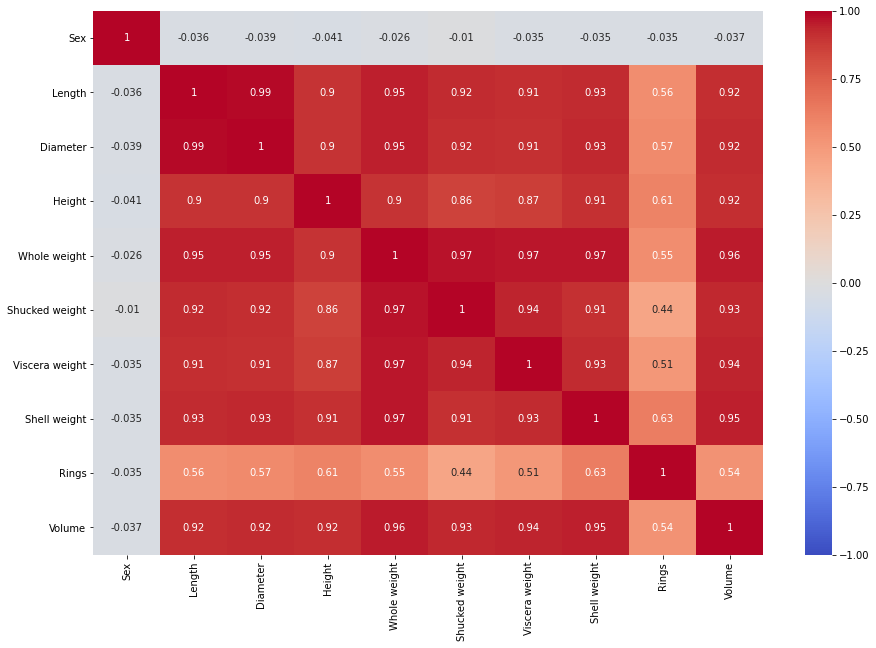

In [7]:
plt.figure(figsize=(15,10))
sns.heatmap(correlation, annot=True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

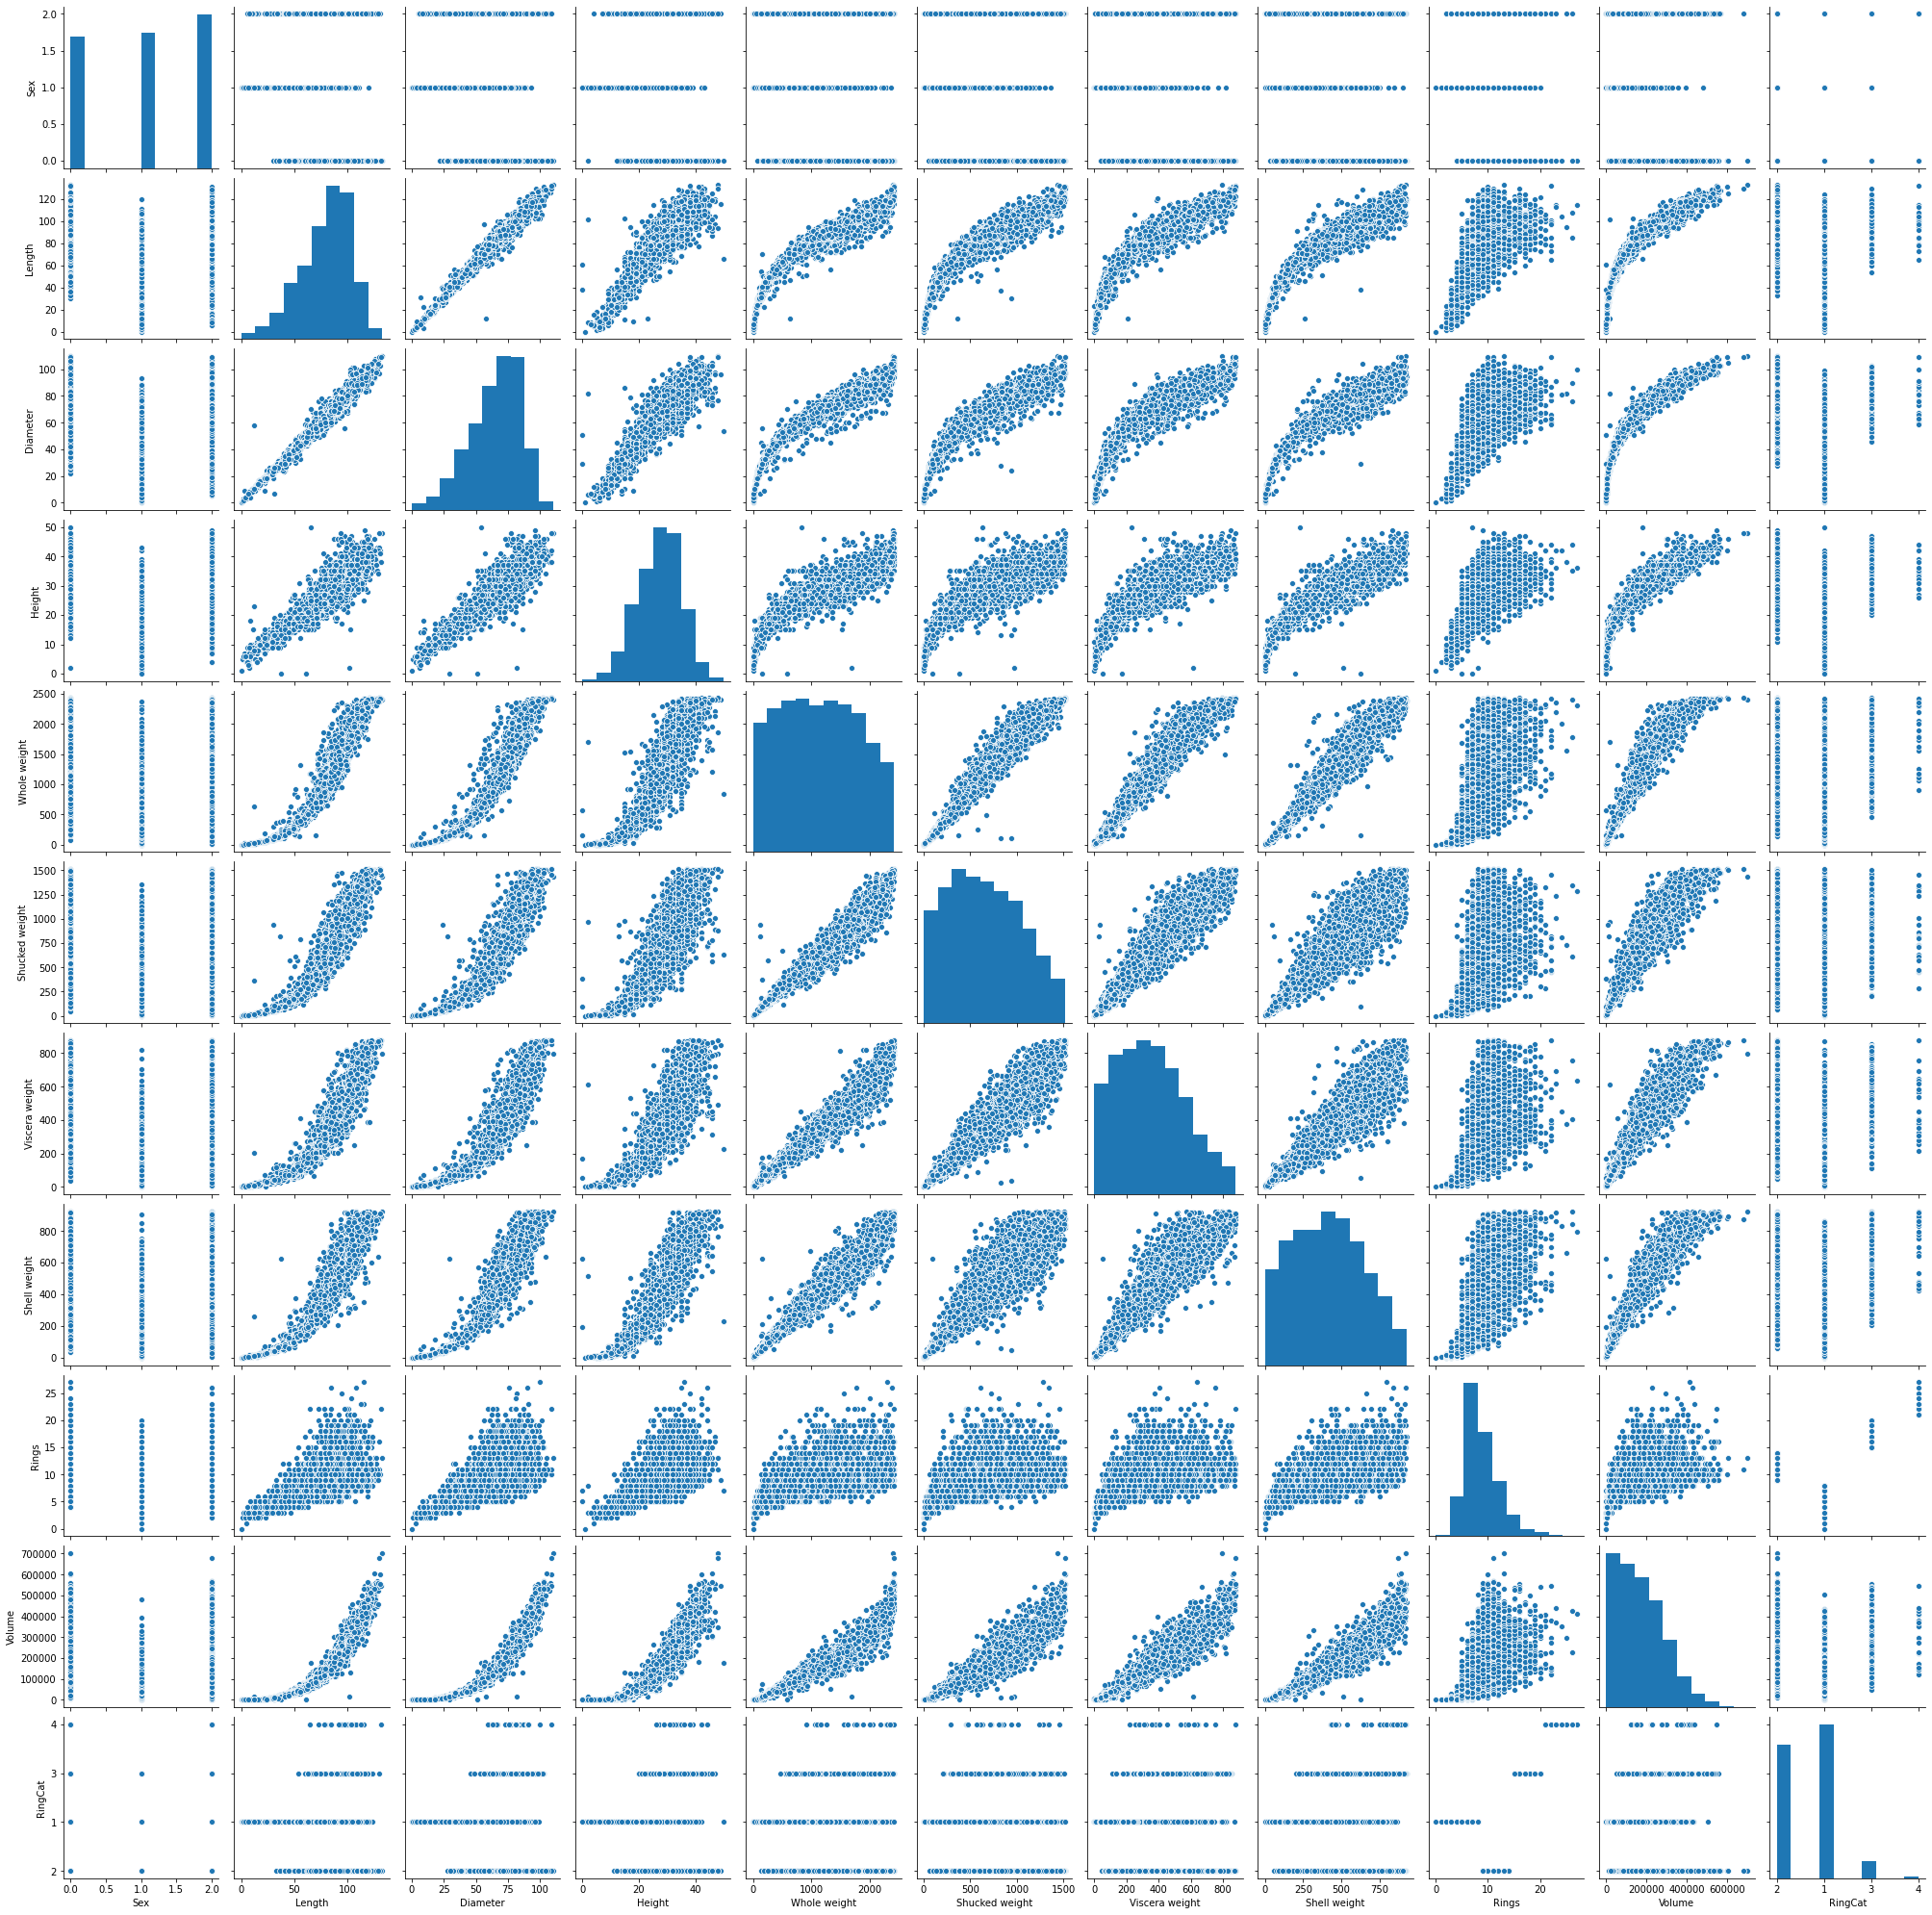

In [8]:
sns.pairplot(data)

In [9]:
data_X = data.drop(columns = ['Rings', 'RingCat', 'Height', 'Length', 'Diameter'], axis=1)/256
data_y = data['RingCat']

data_X = (data_X - np.min(data_X)) / (np.max(data_X) - np.min(data_X)).values

train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.2, random_state=100)

In [10]:
# helper function
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

## Decision Tree

In [11]:
# https://scikit-learn.org/stable/modules/tree.html
# https://deepstat.tistory.com/44
# https://jcabelloc.github.io/machine%20learning/2019/02/27/classification-task.html

dtc = tree.DecisionTreeClassifier(random_state=100)
dtc.fit(train_X, train_y)
predict_y_train = dtc.predict(train_X)
predict_y = dtc.predict(test_X)
print(f"Training accuracy score: {100* accuracy_score(train_y, predict_y_train)}%")
print(f"Testing accuracy Score: {100* accuracy_score(test_y, predict_y)}%")


Training accuracy score: 100.0%
Testing accuracy Score: 64.35406698564593%


### Decision Tree with Pre-prunning

In [12]:
params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}

clf = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=clf,param_grid=params)
gcv.fit(train_X,train_y)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

In [13]:
model = gcv.best_estimator_
model.fit(train_X,train_y)
y_train_pred = model.predict(train_X)
y_test_pred = model.predict(test_X)

print(f'Train score {accuracy_score(y_train_pred,train_y)}')
print(f'Test score {accuracy_score(y_test_pred,test_y)}')

Train score 0.7608500448967375
Test score 0.7272727272727273


### Decision Tree - post Pruning

In [14]:
path = clf.cost_complexity_pruning_path(train_X, train_y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00018956 0.00019702 0.00019954 0.00022448 0.00022448
 0.00023945 0.00023945 0.00023945 0.00023945 0.00023945 0.00024943
 0.00024943 0.00024943 0.00024943 0.00024943 0.00024943 0.00025655
 0.00025655 0.00025655 0.00025655 0.0002619  0.0002619  0.0002619
 0.0002619  0.00026222 0.00026605 0.00026605 0.00026605 0.00026605
 0.00026938 0.00026938 0.00026938 0.00026938 0.00026938 0.00027125
 0.0002721  0.0002721  0.00027366 0.00027437 0.00027437 0.00027437
 0.00027437 0.00027437 0.00027537 0.00027629 0.00027629 0.00027793
 0.00027793 0.00027793 0.00027793 0.00027979 0.0002806  0.0002806
 0.00028171 0.00028171 0.00028171 0.00028171 0.00028268 0.00028356
 0.00028435 0.00028435 0.00028435 0.00028571 0.00028571 0.00028601
 0.0002878  0.00028823 0.00028823 0.00028862 0.00029308 0.00029383
 0.00029585 0.00029931 0.00029931 0.00029931 0.00029931 0.00029931
 0.00029931 0.00029931 0.00029931 0.00029931 0.00029931 0.00029931
 0.00029931 0.00029931 0.00029931 0.00029931 0.00029931 0.000299

In [15]:
# For each alpha we will append our model to a list
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(train_X, train_y)
    clfs.append(clf)

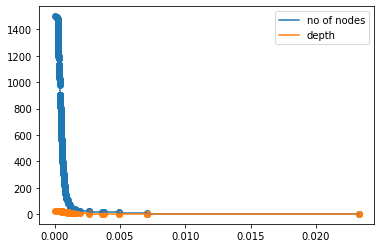

In [16]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

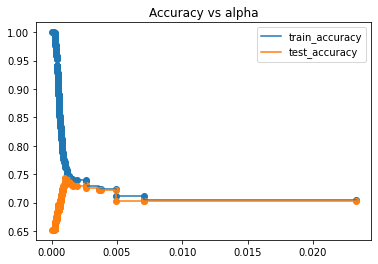

In [17]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(train_X)
    y_test_pred = c.predict(test_X)
    train_acc.append(accuracy_score(y_train_pred,train_y))
    test_acc.append(accuracy_score(y_test_pred,test_y))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

In [18]:
clf = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.018)
clf.fit(train_X,train_y)
y_train_pred = clf.predict(train_X)
y_test_pred = clf.predict(test_X)

print(f'Train score {accuracy_score(y_train_pred,train_y)}')
print(f'Test score {accuracy_score(y_test_pred,test_y)}')

Train score 0.7045794672253817
Test score 0.7021531100478469


In [19]:
 #Computing PCA projection
clf = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.018)
pca = PCA(n_components=6)
pca_train_X= pca.fit(train_X).transform(train_X)
pca_test_X = pca.transform(test_X)
clf.fit(pca_train_X,train_y)
pred_train_y = clf.predict(pca_train_X)
pred_test_y = clf.predict(pca_test_X)

print(f'Train score {accuracy_score(pred_train_y,train_y)}')
print(f'Test score {accuracy_score(pred_test_y,test_y)}')

Train score 0.7225381622268782
Test score 0.7344497607655502


## Neural Network

In [20]:
model = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(5,), solver='lbfgs', max_iter=5000, random_state=18)
model.fit(train_X, train_y)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5,), max_iter=5000,
              random_state=18, solver='lbfgs')

In [21]:
predicted = model.predict(test_X)
print("Classification Report:\n %s:" % (metrics.classification_report(test_y, predicted)))

Classification Report:
               precision    recall  f1-score   support

           1       0.81      0.76      0.78       422
           2       0.68      0.79      0.73       369
           3       0.55      0.15      0.24        40
           4       0.00      0.00      0.00         5

    accuracy                           0.74       836
   macro avg       0.51      0.42      0.44       836
weighted avg       0.73      0.74      0.73       836
:


/Users/worthylafollette/dev/gatech/venv/ml/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
mlp = MLPClassifier(max_iter=5000, random_state=18)
param_list = {"hidden_layer_sizes": [(1,),(5,),(10,)], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00001, 0.00005,0.0005]}

gcv = GridSearchCV(estimator=mlp, param_grid=param_list)
gcv.fit(train_X, train_y)

GridSearchCV(estimator=MLPClassifier(max_iter=5000, random_state=18),
             param_grid={'alpha': [1e-05, 5e-05, 0.0005],
                         'hidden_layer_sizes': [(1,), (5,), (10,)],
                         'solver': ['lbfgs', 'sgd', 'adam']})

In [23]:
print(classification_report(gcv.best_estimator_.predict(test_X), test_y))
print('Best parameters found:\n', gcv.best_params_, gcv.best_score_)

              precision    recall  f1-score   support

           1       0.80      0.81      0.81       414
           2       0.78      0.70      0.74       409
           3       0.15      0.50      0.23        12
           4       0.00      0.00      0.00         1

    accuracy                           0.75       836
   macro avg       0.43      0.50      0.44       836
weighted avg       0.78      0.75      0.76       836

Best parameters found:
 {'alpha': 0.0005, 'hidden_layer_sizes': (10,), 'solver': 'lbfgs'} 0.7342131879738283


In [24]:
# All results
means = gcv.cv_results_['mean_test_score']
stds = gcv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gcv.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.684 (+/-0.183) for {'alpha': 1e-05, 'hidden_layer_sizes': (1,), 'solver': 'lbfgs'}
0.711 (+/-0.028) for {'alpha': 1e-05, 'hidden_layer_sizes': (1,), 'solver': 'sgd'}
0.720 (+/-0.019) for {'alpha': 1e-05, 'hidden_layer_sizes': (1,), 'solver': 'adam'}
0.726 (+/-0.027) for {'alpha': 1e-05, 'hidden_layer_sizes': (5,), 'solver': 'lbfgs'}
0.694 (+/-0.042) for {'alpha': 1e-05, 'hidden_layer_sizes': (5,), 'solver': 'sgd'}
0.727 (+/-0.019) for {'alpha': 1e-05, 'hidden_layer_sizes': (5,), 'solver': 'adam'}
0.734 (+/-0.013) for {'alpha': 1e-05, 'hidden_layer_sizes': (10,), 'solver': 'lbfgs'}
0.721 (+/-0.020) for {'alpha': 1e-05, 'hidden_layer_sizes': (10,), 'solver': 'sgd'}
0.724 (+/-0.024) for {'alpha': 1e-05, 'hidden_layer_sizes': (10,), 'solver': 'adam'}
0.685 (+/-0.184) for {'alpha': 5e-05, 'hidden_layer_sizes': (1,), 'solver': 'lbfgs'}
0.711 (+/-0.028) for {'alpha': 5e-05, 'hidden_layer_sizes': (1,), 'solver': 'sgd'}
0.720 (+/-0.019) for {'alpha': 5e-05, 'hidden_layer_sizes': (1,), 'solver

## Boosting

In [25]:
n_learning_rate_steps, n_folds = 10, 10
learning_rates = np.linspace(0.1, 1.0, num=n_learning_rate_steps)
splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)
trn_err = np.zeros((n_learning_rate_steps, n_folds))
val_err = np.zeros((n_learning_rate_steps, n_folds))
stump = DecisionTreeClassifier(max_depth=1, random_state = 100)
 
for i, rate in enumerate(learning_rates):
    for j, (trn, val) in enumerate(splitter.split(train_X, train_y)):
        model = AdaBoostClassifier(algorithm='SAMME', base_estimator=stump, 
                                   n_estimators=10, learning_rate=rate)
        model.fit(train_X.values[trn, :], train_y.values[trn])
        trn_err[i, j] = 1 - accuracy_score(train_y.values[trn], model.predict(train_X.values[trn, :]))
        val_err[i, j] = 1 - accuracy_score(train_y.values[val], model.predict(train_X.values[val, :]))
trn_err = np.mean(trn_err, axis=1)
val_err = np.mean(val_err, axis=1)
print(f'Training Error {trn_err}, Value Error {val_err}')

Training Error [0.29571983 0.29565325 0.29768192 0.29994377 0.30010961 0.30193868
 0.29778175 0.30572979 0.30074121 0.29156267], Value Error [0.29661811 0.29810886 0.30590044 0.31428099 0.31008669 0.31787738
 0.30590401 0.30649835 0.31308517 0.29990795]


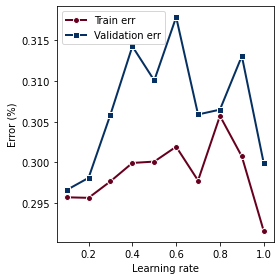

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.plot(learning_rates, trn_err, marker='o', c=cm[0], markeredgecolor='w', linewidth=2)
ax.plot(learning_rates, val_err, marker='s', c=cm[1], markeredgecolor='w', linewidth=2)
ax.legend(['Train err', 'Validation err'])
ax.set_xlabel('Learning rate')
ax.set_ylabel('Error (%)')

fig.tight_layout()

In [27]:
n_estimator_steps, n_folds = 2, 10
number_of_stumps = np.arange(2, 40, n_estimator_steps)
splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)

trn_err = np.zeros((len(number_of_stumps), n_folds))
val_err = np.zeros((len(number_of_stumps), n_folds))

stump = DecisionTreeClassifier(max_depth=1)
for i, n_stumps in enumerate(number_of_stumps):
    for j, (trn, val) in enumerate(splitter.split(train_X, train_y)):
        model = AdaBoostClassifier(algorithm='SAMME', base_estimator=stump,
                                   n_estimators=n_stumps, learning_rate=1.0)
        model.fit(train_X.values[trn, :], train_y.values[trn])

        trn_err[i, j] = 1 - accuracy_score(train_y.values[trn], 
                                           model.predict(train_X.values[trn, :]))
        val_err[i, j] = 1 - accuracy_score(train_y.values[val], 
                                           model.predict(train_X.values[val, :]))

trn_err = np.mean(trn_err, axis=1)
val_err = np.mean(val_err, axis=1)

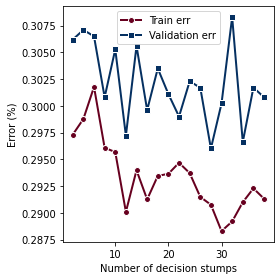

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.plot(number_of_stumps, trn_err, marker='o', c=cm[0], markeredgecolor='w', linewidth=2)
ax.plot(number_of_stumps, val_err, marker='s', c=cm[1], markeredgecolor='w', linewidth=2)
ax.legend(['Train err', 'Validation err'])
ax.set_xlabel('Number of decision stumps')
ax.set_ylabel('Error (%)')

fig.tight_layout()

In [29]:
shallow_tree = DecisionTreeClassifier(max_depth=1)
ensemble = AdaBoostClassifier(base_estimator=shallow_tree, 
                                  n_estimators=22, learning_rate=0.7)
ensemble.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.7, n_estimators=22)

In [30]:
ypred = ensemble.predict(test_X)
acc = accuracy_score(test_y, ypred)
print(f'Accuracy: {acc*100:.2f}%')

Accuracy: 69.98%


## SVM

In [31]:
model = svm.SVC(kernel='rbf', C=30, gamma='auto')
model.fit(train_X, train_y)
print(f'{model.score(test_X, test_y)*100:.2f}%')

74.40%


In [32]:
from sklearn.model_selection import cross_val_score

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report

# https://stackoverflow.com/questions/12632992/gridsearch-for-an-estimator-inside-a-onevsrestclassifier

# model_OVRC = OneVsRestClassifier(svm.LinearSVC(class_weight='balanced', max_iter=10000))
# svm_model = svm.LinearSVC(class_weight='balanced', max_iter=100000)
svm_model = svm.SVC()

parameters = {'C':(0.1, 0.5, 1, 2, 5, 10, 20, 40, 100), 
          "gamma":(0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1), 
          "kernel":('linear', 'poly', 'rbf')
         }

model = GridSearchCV(svm_model, parameters, cv=5)

model.fit(train_X, train_y)
model_predict = model.predict(test_X)

print(classification_report(test_y, model_predict))


              precision    recall  f1-score   support

           1       0.83      0.77      0.80       422
           2       0.68      0.82      0.74       369
           3       0.00      0.00      0.00        40
           4       0.00      0.00      0.00         5

    accuracy                           0.75       836
   macro avg       0.38      0.40      0.39       836
weighted avg       0.72      0.75      0.73       836



/Users/worthylafollette/dev/gatech/venv/ml/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## KNN

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [35]:
KNN_Model = KNeighborsClassifier(n_neighbors=2).fit(train_X, train_y)

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci

In [36]:
y_scores = KNN_Model.predict_proba(test_X)

macro_roc_auc_ovo = roc_auc_score(test_y, y_scores, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(test_y, y_scores, multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(test_y, y_scores, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(test_y, y_scores, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))


One-vs-One ROC AUC scores:
0.638289 (macro),
0.687711 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.675187 (macro),
0.749627 (weighted by prevalence)


In [37]:
print(f'2 NN Score: {KNN_Model.score(test_X, test_y)*100:.2f}%')

2 NN Score: 66.39%


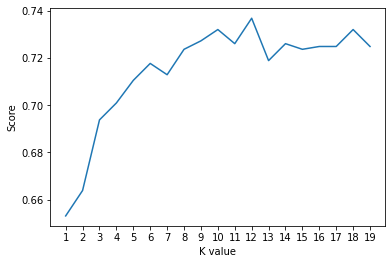

Maximum KNN Score is 73.68%


In [38]:
# try to find best k value
scoreList = []
for i in range(1,20):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(train_X, train_y)
    scoreList.append(knn2.score(test_X, test_y))
    
plt.plot(range(1,20), scoreList)
plt.xticks(np.arange(1,20,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100
print(f'Maximum KNN Score is {acc:.2f}%')